# Inferring distances with Gaia data.

Your goal is to infer the distances to stars using Gaia parallaxes. Inverting the parallax will give you an inaccurate distance when the parallax uncertainty is large, so it is better to infer distance. There are two ways you could do this: 1) infer the distance using a sensible prior, as used in [Bailer-Jones et al. (2019)](https://arxiv.org/pdf/1804.10121.pdf), OR infer the prior using HBM.

We're going to do both.

First, lets open the data file, "parallaxes.csv".

In [22]:
import pandas as pd
df = pd.read_csv("parallaxes.csv")
df = df[df.parallax_error > 0]
df = df.iloc[:100]
df.head()

,Unnamed: 0,parallax_mas,parallax_error,true_distance_kpc
0,0,1.672053,0.018477,0.591963
1,1,0.375761,0.035355,2.457926
2,2,0.529537,0.038041,1.920681
3,3,1.104286,0.018510,0.901326
4,4,1.011174,0.021886,0.949794


We could just calculate the distances using 1/parallax. 

*Plot true distance against 1./parallax.*

Text(0, 0.5, '1/parallax')

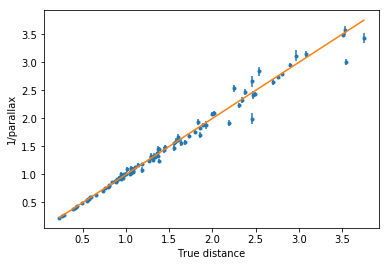

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rel_err = df.parallax_error/df.parallax_mas
plt.errorbar(df.true_distance_kpc, 1./df.parallax_mas, yerr=rel_err, fmt=".")

x = np.linspace(min(df.true_distance_kpc), max(df.true_distance_kpc), 100)
plt.plot(x, x, zorder=10);

plt.xlabel("True distance")
plt.ylabel("1/parallax")

Let's first try to infer distances using the [Bailer-Jones prior](https://arxiv.org/pdf/1804.10121.pdf).

*Draw the non-hierarchical and hierarchical PGMs for this problem. In the hierarchical version, L will be a free parameter.*

*Using PyMC3, infer the distance to each star with the non-hierarchical model.*

In [24]:
import pymc3 as pm

L = 500
logL = np.log(L)

with pm.Model() as simple_model:
        
    # Prior over distance as a pymc3 potential object
    D = pm.Uniform("D", lower=0, upper=1000, shape=len(df),
                   testval=np.array(1. / df.parallax_mas))
    r = 1e3 * D
    pm.Potential("lnprior", -3*logL + 2*pm.math.log(r) - r/L)
    
    # The model
    mu = 1. / D

    # Likelihood
    pm.Normal("parallax_obs", mu=mu, sigma=np.array(df.parallax_error),
              observed=np.array(df.parallax_mas))
    
    simple_trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:15<00:00, 2637.10draws/s]


Text(0, 0.5, 'Measured distance [kpc]')

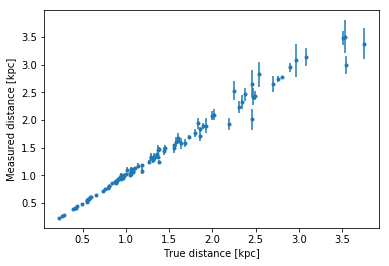

In [25]:
plt.errorbar(df.true_distance_kpc,
             np.mean(simple_trace["D"], axis=0),
             yerr=np.std(simple_trace["D"], axis=0), fmt=".");
plt.xlabel("True distance [kpc]")
plt.ylabel("Measured distance [kpc]")

In [26]:
with pm.Model() as hierarchical_model:
    
    logL = pm.Normal("logL", mu=np.log(500), sd=10)
    L = pm.Deterministic("L", pm.math.exp(logL))
        
    # Prior over distance as a pymc3 potential object
    D = pm.Uniform("D", lower=0, upper=1000, shape=len(df),
                   testval=np.array(1. / df.parallax_mas))
    r = 1e3 * D
    pm.Potential(
        "lnprior", -3*logL + 2*pm.math.log(r) - r/L)
    
    # The model
    mu = 1. / D

    # Likelihood
    pm.Normal(
        "parallax_obs", mu=mu, sigma=np.array(df.parallax_error),
        observed=np.array(df.parallax_mas))
    
    hierarchical_trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D, logL]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:16<00:00, 2408.65draws/s]


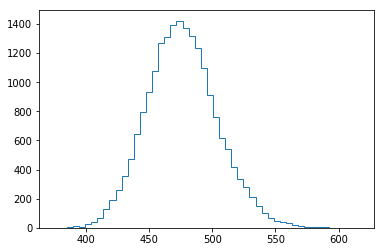

In [27]:
plt.hist(hierarchical_trace["L"], 50, histtype="step");

# Bonus exercises

Choose one of the following:

*1) Redo this analysis with emcee.*

*2) Redo this analysis, in PyMC3, where you don't know, or don't trust, the uncertainties on the parallaxes.*

*3) Reproduce the file "parallaxes.csv". How did I sample from the prior distribution?*

In [ ]:
def lnprob(r_kpc, parallax_mas, parallax_mas_error):
    lnlike = -.5*np.sum((1./r_kpc - parallax_mas)**2/parallax_mas_error**2)
    
    if r_kpc > 0:
        lnprior = log_bj_prior(r_kpc, 500)
    else:
        lnprior = -np.inf
    return lnlike + lnprior

print(lnprob(1, 1, .1))
print(lnprob(1, 5, .1))
print(lnprob(5, 1./5, .001))
print(lnprob(5, 10, .001))

import emcee
import corner

ndim, nwalkers = 1, 100
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[df.parallax_mas[0], df.parallax_error[0]])
sampler.run_mcmc(p0, 1000, progress=True);

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print("true = ", df.true_distance_kpc[0])
print("inferred = ", np.median(samples, axis=0))